# Implementation of Neural Style Transfer with PyTorch

In [ ]:
# importing libraries to implement style-transfer

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn.functional as nnf
# desired size of the output image
imsize = 1024 if torch.cuda.is_available() else 128  # use small size if no gpu


loader = transforms.Compose([
    transforms.Resize([imsize, imsize]),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    print(image.size())
    return image.to(device, torch.float)

content_img = image_loader("/content/grand_central_color.png")
style_img = image_loader("/content/cexp.jpg")

# assert style_img.size() == content_img.size(), \
#     "we need to import style and content images of the same size"

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


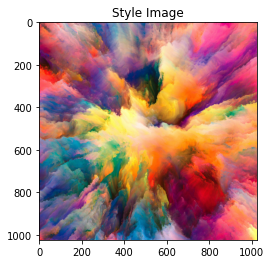

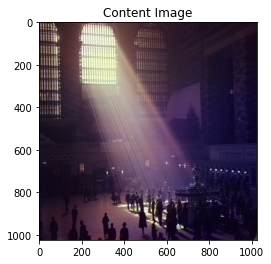

In [ ]:
# visualizing the content and style images
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
# importing vgg-16 pre-trained model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

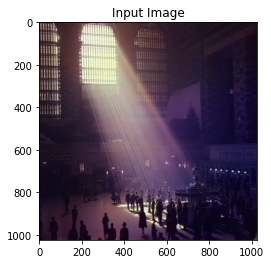

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 169.498093 Content Loss: 11.379322

run [100]:
Style Loss : 69.833328 Content Loss: 10.442320

run [150]:
Style Loss : 30.170019 Content Loss: 9.058325

run [200]:
Style Loss : 16.297728 Content Loss: 8.918723

run [250]:
Style Loss : 7.273488 Content Loss: 8.628643

run [300]:
Style Loss : 3.490482 Content Loss: 8.058701

run [350]:
Style Loss : 2.627701 Content Loss: 7.422360

run [400]:
Style Loss : 1.900877 Content Loss: 6.991122

run [450]:
Style Loss : 1.556533 Content Loss: 6.733058

run [500]:
Style Loss : 1.321723 Content Loss: 6.555291

run [550]:
Style Loss : 1.138032 Content Loss: 6.443450

run [600]:
Style Loss : 0.943427 Content Loss: 6.353770

run [650]:
Style Loss : 0.896297 Content Loss: 6.298394

run [700]:
Style Loss : 0.669508 Content Loss: 6.224366

run [750]:
Style Loss : 0.577737 Content Loss: 6.193426

run [800]:
Style Loss : 0.527853 Content Loss: 6.142999

run [850]:
Style Loss : 0.493854 Content Loss: 6.109035

run [900]:
Style Loss : 0

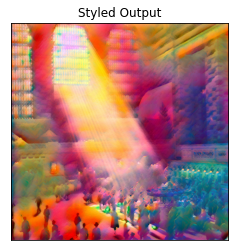

In [ ]:
styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=900, style_weight=500000, content_weight=1)
# save styled image
from torchvision.utils import save_image 
save_image(styled_output, "styledimage.jpg")

plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled_output, title='Styled Output')

plt.show()

In [ ]:
# save styled image
from torchvision.utils import save_image 
save_image(styled_output, "grand_central_color.jpg")

In [ ]:
for steps in range(100, 1500, 200):
  styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=300, style_weight=500000, content_weight=1)
  # save styled image
  from torchvision.utils import save_image 
  save_image(styled_output, "stylised_gt_bio_" + str(steps) + ".jpg")
  print("stylised_gt_bio_" + str(steps) + ".jpg")

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 0.858559 Content Loss: 6.199967

run [100]:
Style Loss : 0.757598 Content Loss: 5.896371

run [150]:
Style Loss : 0.670283 Content Loss: 5.727593

run [200]:
Style Loss : 0.587304 Content Loss: 5.607906

run [250]:
Style Loss : 0.543636 Content Loss: 5.518894

run [300]:
Style Loss : 0.510976 Content Loss: 5.457138

stylised_gt_bio_100.jpg
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.483827 Content Loss: 5.376276

run [100]:
Style Loss : 0.471661 Content Loss: 5.339974

run [150]:
Style Loss : 0.471314 Content Loss: 5.326156

run [200]:
Style Loss : 0.464215 Content Loss: 5.335809

run [250]:
Style Loss : 0.459864 Content Loss: 5.380840

run [300]:
Style Loss : 0.454150 Content Loss: 5.397437

stylised_gt_bio_300.jpg
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.424622 Content Loss: 5.303663

run [100]:
Style Loss : 0.401806 Content Loss: 5.227747

run [150]:
Style Loss : 0.393995 Content Loss: 5.190854

ru

KeyboardInterrupt: ignored

(-0.5, 1023.5, 1023.5, -0.5)

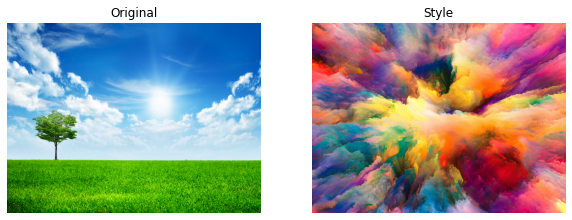

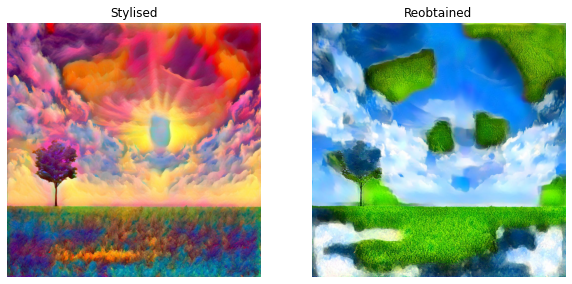

In [ ]:
from PIL import Image
import numpy
original_image = numpy.array(Image.open("one.jpg"))
style_image = numpy.array(Image.open("cexp.jpg"))
stylised_image = numpy.array(Image.open("one-stylised.jpg"))
reobtained_image = numpy.array(Image.open("re-one.jpg"))

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title('Style')
plt.axis('off')

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(stylised_image)
plt.title('Stylised')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reobtained_image)
plt.title('Reobtained')
plt.axis('off')